## Rossman Sales Prediction

Spring 2025 CMSC320 Final Project

Collaborators: Marvin Lin, Christopher Su, Tanish Bollam, Ayan Banerjee

### Contributions:

Marvin: Introduction, Data Exploration and Summary, Follow Up Data Exploration, ML Model Design and Development (Not Forecasting)

Chris: Introduction, Data Curation, Data Exploration and Summary, ML Model Design and Development (Words).

Tanish: Introduction, ML Model Design and Development (Forecasting), Training and Analysis (Forecasting)

Ayan:

## Introduction:

**Introduction**
For our final project in CMSC320, we are analyzing the Rossmann Store Sales dataset, originally published by Florian Knauer and Will Cukierski (2015) on Kaggle. This dataset contains historical sales data for over 1,000 Rossmann stores across several years, with features including daily sales figures, customer counts, promotional activity, store-specific attributes, and more.

**About Rossman**
Rossmann is a leading drugstore chain with over 3,000 locations across seven European countries. Store managers are currently responsible for forecasting daily sales up to six weeks ahead. However, sales performance is affected by a wide range of factors, including promotions, local competition, holidays, seasonal trends, and store-specific characteristics. With each manager relying on their own judgment and local knowledge, the consistency and accuracy of these forecasts can vary significantly.



**Research Question**
Our primary goal is to answer the question:
Can we accurately predict daily sales for a given store using historical data and store-level features?
To do this, we will develop a machine learning model that forecasts future store sales based on past trends and available metadata.

**Motivation**
Forecasting sales is a crucial task for retail businesses. Accurate predictions enable better inventory planning, workforce allocation, and promotional strategy. With the rise of data-driven decision-making, being able to reliably anticipate future demand gives stores a competitive edge. By tackling this problem, we hope to gain insight into how various factors—such as promotions, holidays, and store type—impact daily sales performance.



## Data Curation

This part of the project involves searching for and collecting relevant data from several sources. 

We will begin by importing relevant Python libraries necessary for this process.

**Imports**

In [2]:
import pandas as pd
import numpy as np

# Libraries for hypothesis testing
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

These libraries are necessary in the data science process. 

* **Pandas** is a library used for data manipulation and analysis. It provides data structures such as DataFrame and Series that allow us to efficiently handle structured data.
* **Numpy** is a a fundamental library for numerical computing. It offers support for arrays, functions, linear algebra, and statistical operations among functionality.
* **Scikit-learn** is a library primarily used for machine learning. It provides efficent tools for data analysis and modeling. These tasks include classification, regression, clustering, and dimensionality reduction.
* **Scipy-stats** is a module within scipy the SciPy library that provides various functions for statistical computations. These include probability distributions, statistical tests, descriptive statistics, etc.
* **Matplotlib** and **seaborn** are data visualization libraries for creating visualizations in Python such as line graphs, histograms, bar charts, etc.

Next, we must choose a relevant dataset for our topic. Based on our objective of predicting future store sales based on historical data, we chose the [Rossmann Store Sales dataset](https://www.kaggle.com/competitions/rossmann-store-sales) to work with. Rossmann is one of the largest drug store chains in Europe, with over 4000 stores. This dataset includes key features such as Date, Customers, Sales, Store information, Promotions, etc that will be important for predicting future sales. It includes historical sales data for 1,115 Rossmann stores. 

The data is split into the following files:
* **train.csv** - historical data including Sales.
* **test.csv** - historical data excluding Sales.
* **store.csv** - supplemental information about the stores.

After downloading these datasets, we can begin by loading them into pandas DataFrames.

In [3]:
# Load data into pandas DataFrames
train_df = pd.read_csv('DATASETS/train.csv', low_memory=False)
test_df = pd.read_csv('DATASETS/test.csv', low_memory=False)
store_df = pd.read_csv('DATASETS/store.csv', low_memory=False)

We use these two datasets and exclude **test.csv** because the information is already included in **train.csv**. The next step is to combine these into one DataFrame 

## Data Preprocessing

In [4]:
df = pd.merge(train_df, store_df, on='Store', how='left')
test_df = pd.merge(test_df, store_df, on='Store', how='left')

The **train_df** and **test_df** dataframes only include a Store identifier. However, each store has associated attributes (StoreType, Assortment, CompetitionDistance, etc.) in store_df that are crucial for modeling sales. The how='left' parameter in pd.merge ensures that all rows from train_df are preserved. 

By doing a left join on the dataframes, we ensure every record in your training and testing data includes relevant store features. This helps your machine learning model learn how differences between stores affect sales.

In [5]:
# label encode all the following columns
cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

In [6]:
# converting string numbers into just numbers
cols = ['Open', 'Promo', 'Promo2', 'SchoolHoliday']
for col in cols:
    df[col] = df[col].astype(int)

In [7]:
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int32
Promo                          int32
StateHoliday                   int32
SchoolHoliday                  int32
StoreType                      int32
Assortment                     int32
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int32
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int32
dtype: object

## Data Exploration & Summary Statistics

In this section, we’ll perform basic exploration and summary statistics to get a sense of the dataset. We'll check for missing values, understand the distribution of sales, and explore how sales vary across store types and promotional periods. We'll also generate a correlation heatmap to identify relationships between numeric features, which can help guide feature selection and modeling decisions. These steps help uncover patterns, spot potential data issues, and build intuition about what drives sales.

First, let's observe the shape and types of our dataset.

In [8]:
# shape of datasets
print(df.shape)

(1017209, 18)


Our dataframe has 1017209 rows and 18 columns. The rows correspond to the number of entries, and the columns correspond to the number of features.

In [9]:
# types of each column
print(df.dtypes)

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int32
Promo                          int32
StateHoliday                   int32
SchoolHoliday                  int32
StoreType                      int32
Assortment                     int32
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int32
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int32
dtype: object


Here, we can observe the datatype of each column.

In [10]:
# descriptive statistics for each column.
print(df.describe())

              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  StateHoliday  SchoolHoliday     StoreType    Assortment  \
count  1.017209e+06  1.017209e+06   1.017209e+06  1.017209e+06  1.017209e+06   
mean   3.815145e-01  4.516279e-02   1.786467e-01  1.207467e+00  9.351412e-01   
std    4.857586e-01  2.836559e-01   3.830564e-01

Here, we have descriptive statistics for each column. These are count, mean, standard deviation, min, max, and quartiles.

It is also important that we understand and account for missing data. Below, we check the amount of missing data in each feature and output the result.

In [11]:
# find any missing data
missing = df.isnull().sum()
print(missing[missing > 0])

CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
dtype: int64


Next, let's plot a few basic statistics for our dataset. We will plot the distribution, sales by store type, effect of promotions on sales, and a correlation heatmap.

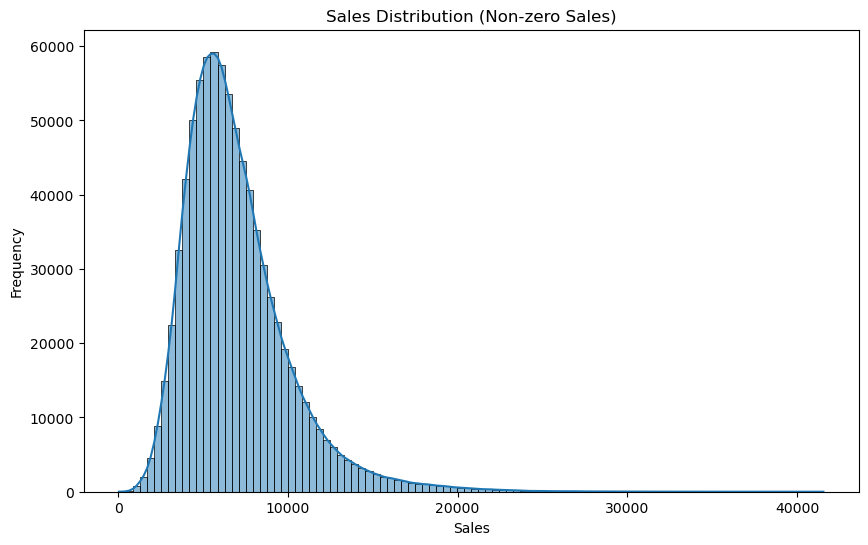

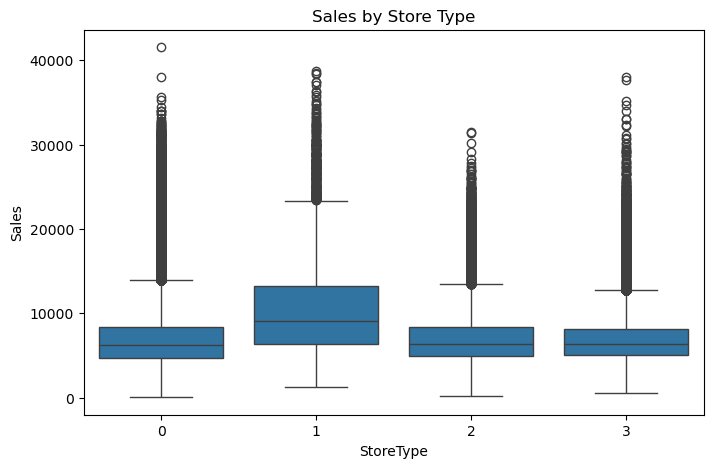

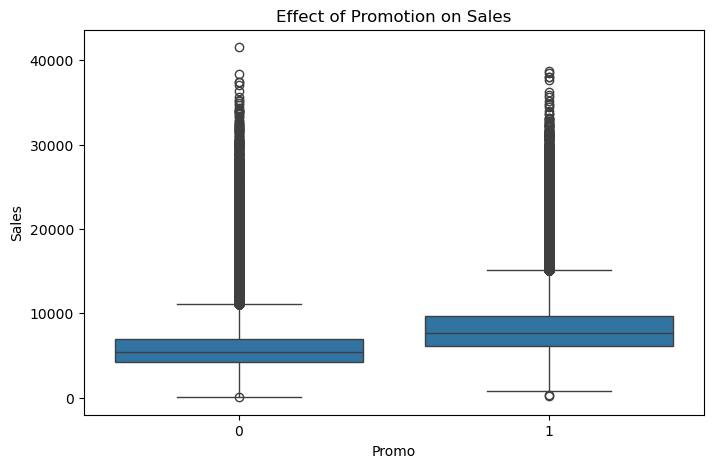

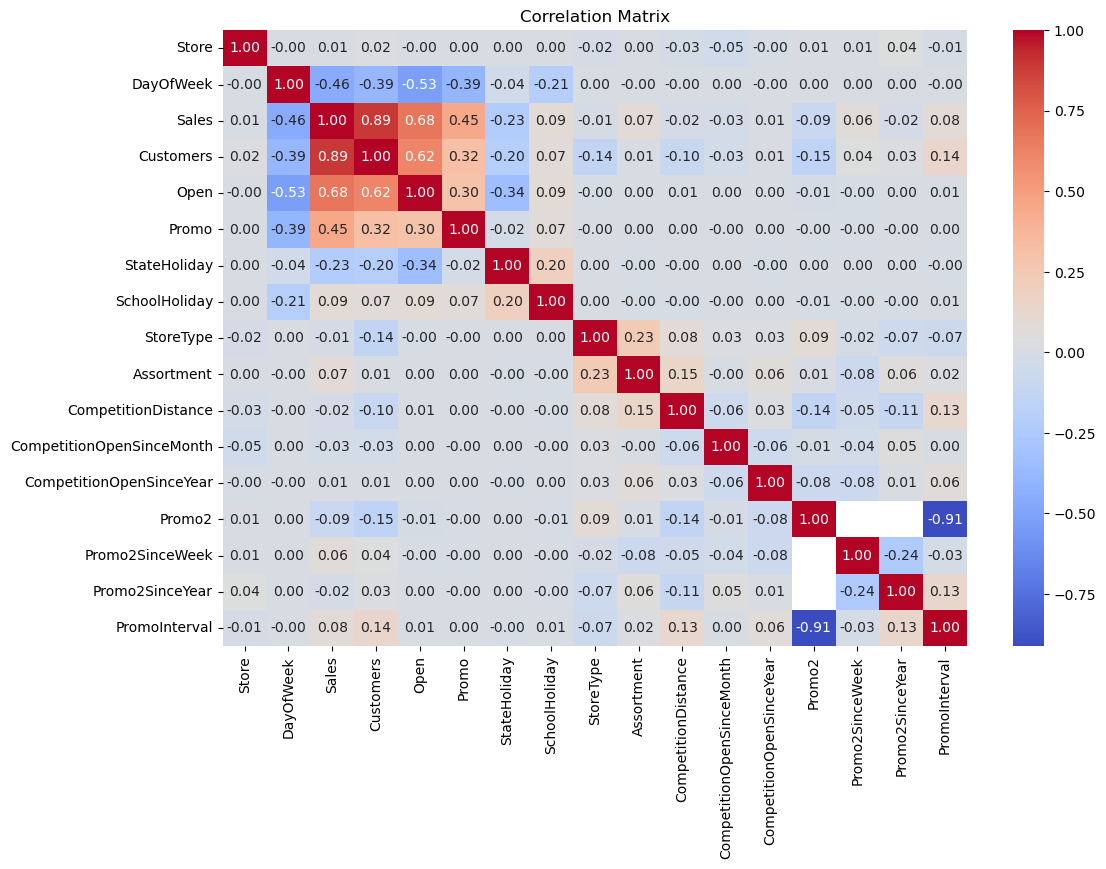

In [12]:
# imports to plot some basic data
import matplotlib.pyplot as plt
import seaborn as sns

# Sales distribution graph
plt.figure(figsize=(10, 6))
sns.histplot(df[df["Sales"] > 0]["Sales"], bins=100, kde=True)
plt.title("Sales Distribution (Non-zero Sales)")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

# Sales by store type
plt.figure(figsize=(8, 5))
sns.boxplot(x="StoreType", y="Sales", data=df[df["Sales"] > 0])
plt.title("Sales by Store Type")
plt.show()

# Promo effect on sales
plt.figure(figsize=(8, 5))
sns.boxplot(x="Promo", y="Sales", data=df[df["Sales"] > 0])
plt.title("Effect of Promotion on Sales")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The distribution of sales is highly right-skewed, with most values concentrated between €2,000 and €10,000, and a long tail of higher sales. This skew suggests the need for models that can handle non-normal target distributions. Boxplots comparing store types show that Store Type 1 generally generates higher median sales than other types, with wider variability, hinting that store format influences performance. Similarly, the promotion boxplot confirms that Promo periods are associated with significantly higher sales, reinforcing the importance of marketing efforts. The correlation matrix highlights strong positive relationships between Sales, Customers, and Promo, with Customers having the highest direct correlation to Sales (0.89). It also reveals relatively weak or no correlation for most other features, indicating potential interactions or non-linear effects rather than simple additive contributions.

# Follow Up Data Exploration

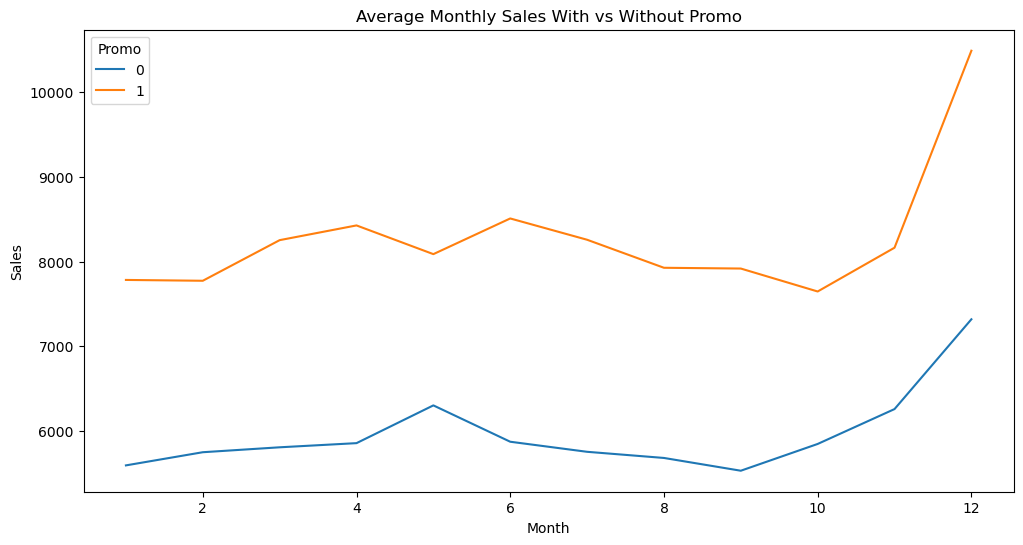

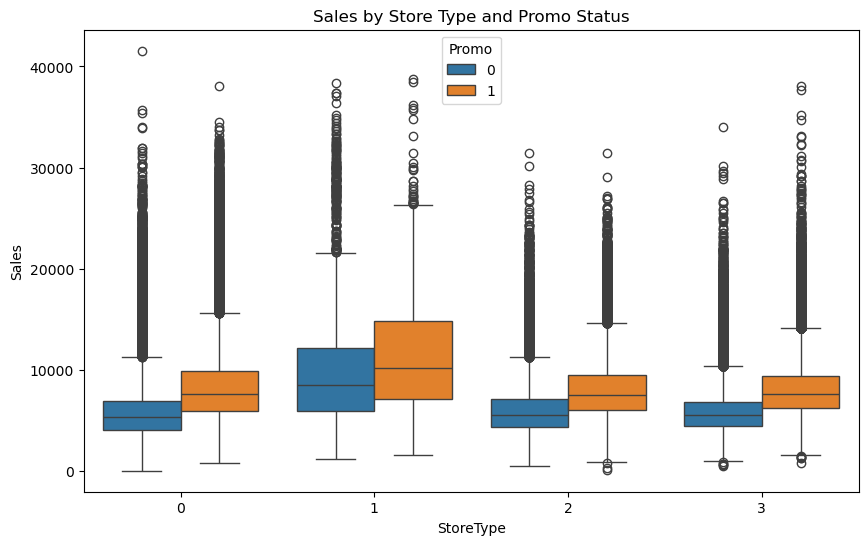

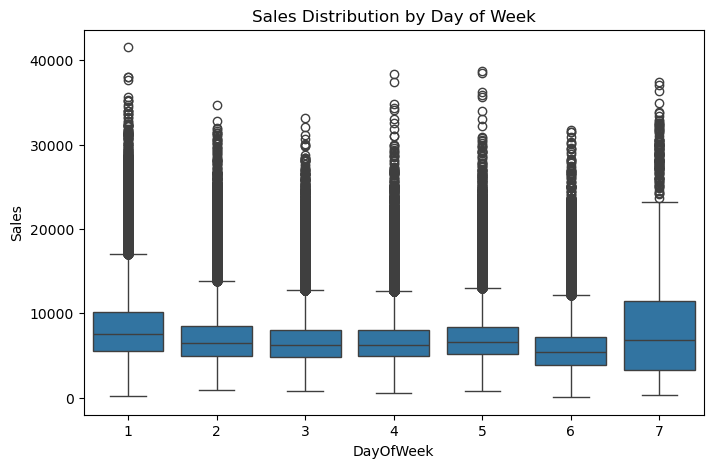

In [13]:
# Sales trends over time (Promo vs Non-Promo by Month)
import matplotlib.pyplot as plt
import seaborn as sns

df_model_full = df.copy()
df_model_full["Date"] = pd.to_datetime(df_model_full["Date"])
df_model_full["Month"] = df_model_full["Date"].dt.month
df_model_full["Year"] = df_model_full["Date"].dt.year

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_model_full[df_model_full["Sales"] > 0],
             x="Month", y="Sales", hue="Promo", errorbar=None, estimator="mean")
plt.title("Average Monthly Sales With vs Without Promo")
plt.show()

# StoreType and Promo interaction
plt.figure(figsize=(10, 6))
sns.boxplot(x="StoreType", y="Sales", hue="Promo", data=df_model_full[df_model_full["Sales"] > 0])
plt.title("Sales by Store Type and Promo Status")
plt.show()

# Day of Week trends
plt.figure(figsize=(8, 5))
sns.boxplot(x="DayOfWeek", y="Sales", data=df_model_full[df_model_full["Sales"] > 0])
plt.title("Sales Distribution by Day of Week")
plt.show()

Sales are consistently higher during promotions, with a sharp increase in December, likely due to holiday shopping. Store Type 1 sees the highest sales overall and responds best to promotions, suggesting store format influences promo effectiveness. Day-of-week trends show Sunday has the lowest median sales, while weekdays are relatively stable. These patterns highlight the importance of incorporating promotion status, store type, and calendar features into the model.

## ML Algorithm Design & Development

This code builds and evaluates regression models to predict daily store sales based on features such as store type, promotional activity, assortment strategy, and calendar information like day, month, and year. Using the cleaned Rossmann dataset, it trains three models, Linear Regression, Random Forest, and XGBoost, and assesses their performance using 5-fold cross-validation. The models are scored using root mean squared error (RMSE) to measure how accurately they can estimate sales for open stores on days with non-zero transactions.

**Imports**: Load core libraries for data manipulation (pandas, numpy), preprocessing, modeling (scikit-learn, xgboost), and evaluation.

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

**Filter** the dataset to removed closed stores and entries with zero sales to avoid skewing the model.

In [30]:
# Filter dataset
df_model = df[(df["Open"] == 1) & (df["Sales"] > 0)].copy()

**Convert** dates to datetime and extract components to capture seasonal trends.

In [31]:
# Extract date
df_model["Date"] = pd.to_datetime(df_model["Date"])
df_model["Year"] = df_model["Date"].dt.year
df_model["Month"] = df_model["Date"].dt.month
df_model["Day"] = df_model["Date"].dt.day

**Encode** string categories into numerical codes for the ML model.

In [32]:
# label encoding
label_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in label_cols:
    df_model[col] = df_model[col].fillna("Missing").astype(str)
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

**Remove** columns that are not used for training.

In [33]:
# remove unused columns
df_model.drop(["Date", "Customers", "Open"], axis=1, inplace=True)

**Define** inputs (X) and output (Y) for modeling.

In [34]:
# split features and targetD: ML Algorithm Design/Development
X = df_model.drop("Sales", axis=1)
y = df_model["Sales"]

Handle **missing** values with mean imputation, which is replacing each missing value with the mean of the column.

In [35]:
# handle missing values
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

**Define** regression models for training and comparison.

In [51]:
# models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42)
}

Create a root mean squared error **(RMSE)** function to score each model.

In [52]:
# score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

## ML Algorithm Training & Analysis

Run **cross-validation** to compare model performance using RMSE.

In [54]:
# cross validate with k-fold (5 folds)
for name, model in models.items():
    print(f"--- {name} ---")
    scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer)
    print(f"CV RMSE (mean ± std): {-scores.mean():.2f} ± {scores.std():.2f}\n")

--- Linear Regression ---
CV RMSE (mean ± std): 2800.26 ± 76.48

--- Random Forest ---
CV RMSE (mean ± std): 1132.34 ± 97.21

--- XGBoost ---
CV RMSE (mean ± std): 1818.25 ± 32.16



In our 5-fold cross-validation on the Rossmann sales data, Random Forest achieved the best performance with a mean RMSE of 1132.34, significantly outperforming both XGBoost (1818.25) and Linear Regression (2800.26). This indicates that Random Forest is well-suited for capturing the dataset’s non-linear patterns. XGBoost, while more consistent across folds, underperformed likely due to untuned hyperparameters. Linear Regression had the highest error, suggesting it is too simplistic for the complexity of the sales dynamics. Overall, Random Forest currently offers the most accurate and balanced performance.

Let's try tuning XGBoost to use more trees (helps since the dataset is large and complex), smaller step size, standard tree depth, and introduce random sampling for robustness

In [58]:

models["XGBoost"] = XGBRegressor( n_estimators=1500, learning_rate=0.04, max_depth=8, min_child_weight=3, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42)

name = "XGBoost"
model = models[name]
print(f"--- {name} ---")
scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer)
print(f"CV RMSE (mean ± std): {-scores.mean():.2f} ± {scores.std():.2f}\n")


--- XGBoost ---
CV RMSE (mean ± std): 1045.19 ± 30.22



In [60]:
# calculate daily sales stats
daily_sales = df[(df["Open"] == 1) & (df["Sales"] > 0)].copy()
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"])
sales_per_day = daily_sales.groupby("Date")["Sales"].mean()

# calculate average and median sales
avg_sales = sales_per_day.mean()
median_sales = sales_per_day.median()

print(f"Average daily sales across all stores: {avg_sales:.2f}")
print(f"Median daily sales across all stores: {median_sales:.2f}")

# Compare to RMSE (you can paste your actual RMSE value here)
rmse_val = 1000  # replace with your actual RMSE
print(f"Relative error vs. avg: {rmse_val / avg_sales * 100:.2f}%")
print(f"Relative error vs. median: {rmse_val / median_sales * 100:.2f}%")


Average daily sales across all stores: 7254.28
Median daily sales across all stores: 7055.63
Relative error vs. avg: 13.78%
Relative error vs. median: 14.17%


**Interpreting Results:**

Our tuned XGBoost with more parameters outperforms Random Forest, but by a slim margin. This indicates a rough "best performance" on this dataset by tree based methods.

A RMSE of ~1000 indicates that predictions of sales are off by roughly 1000. As the median for stores is roughly 7000, this is quite a strong performance with only a 13% error. 

## ML (Forecasting) Algorithm Design & Development

For this project, we will also be forecasting the future sales for the different type of Rossman stores. We specifically used the Prophet model by Meta, a time series forecasting tool. Prophet is a generalized additive model (GAM) that decomposes time series data into three main components: trend, seasonality (weekly, yearly), and holiday effects. This will allow users to incorporate specific events and automatically handles missing data, outliers, and irregular time series well.

To support the forecasting model, the dataset was cleaned and preprocessed:

- Categorical columns like StateHoliday were converted to numerical codes.

- Missing values were imputed using mean values for numerical columns and default values (0) for categorical flags.

- Visualizations were created to explore data quality, holiday effects, and store open/close behavior to inform model configuration.


First, import all the required libraries required for this. We used pandas, numpy, matplotlib, statsmodels, and prophet. 



In [ ]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import the required libraries for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# import the forecasting library which in this case, we are using Meta's Prophet because it is a powerful library for time series forecasting
# and is particularly well-suited for handling seasonal data with holidays and other events.
from prophet import Prophet

After this, we load in the dataset. 

In [ ]:
# load the sales dataset for later use
data = pd.read_csv("DATASETS/train.csv", low_memory=False)


Then, we clean the data set. When we clean the dataset, we first convert the date t date time format. Then we filter out the rows where teh store is closed or has 0 sales. Lastly, we put all the sales in float format so it is easy to work with later. 

In [ ]:
# convert the 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# filter out rows where the store is closed or sales are zero. These rows are not useful for time series modeling.
filtered_data = data[(data['Open'] != 0) & (data['Sales'] > 0)].copy()

# ensure 'Sales' is in float format for numerical processing
filtered_data['Sales'] = filtered_data['Sales'].astype(float)

Then, we set up the stores and select one store from each type to represent it

In [ ]:
# select one store from each store type to represent its trend. 
stores = {
    "A": 2,
    "B": 85,
    "C": 1,
    "D": 13
}


Next, we pplot the weekly data for each of the selected stores. 

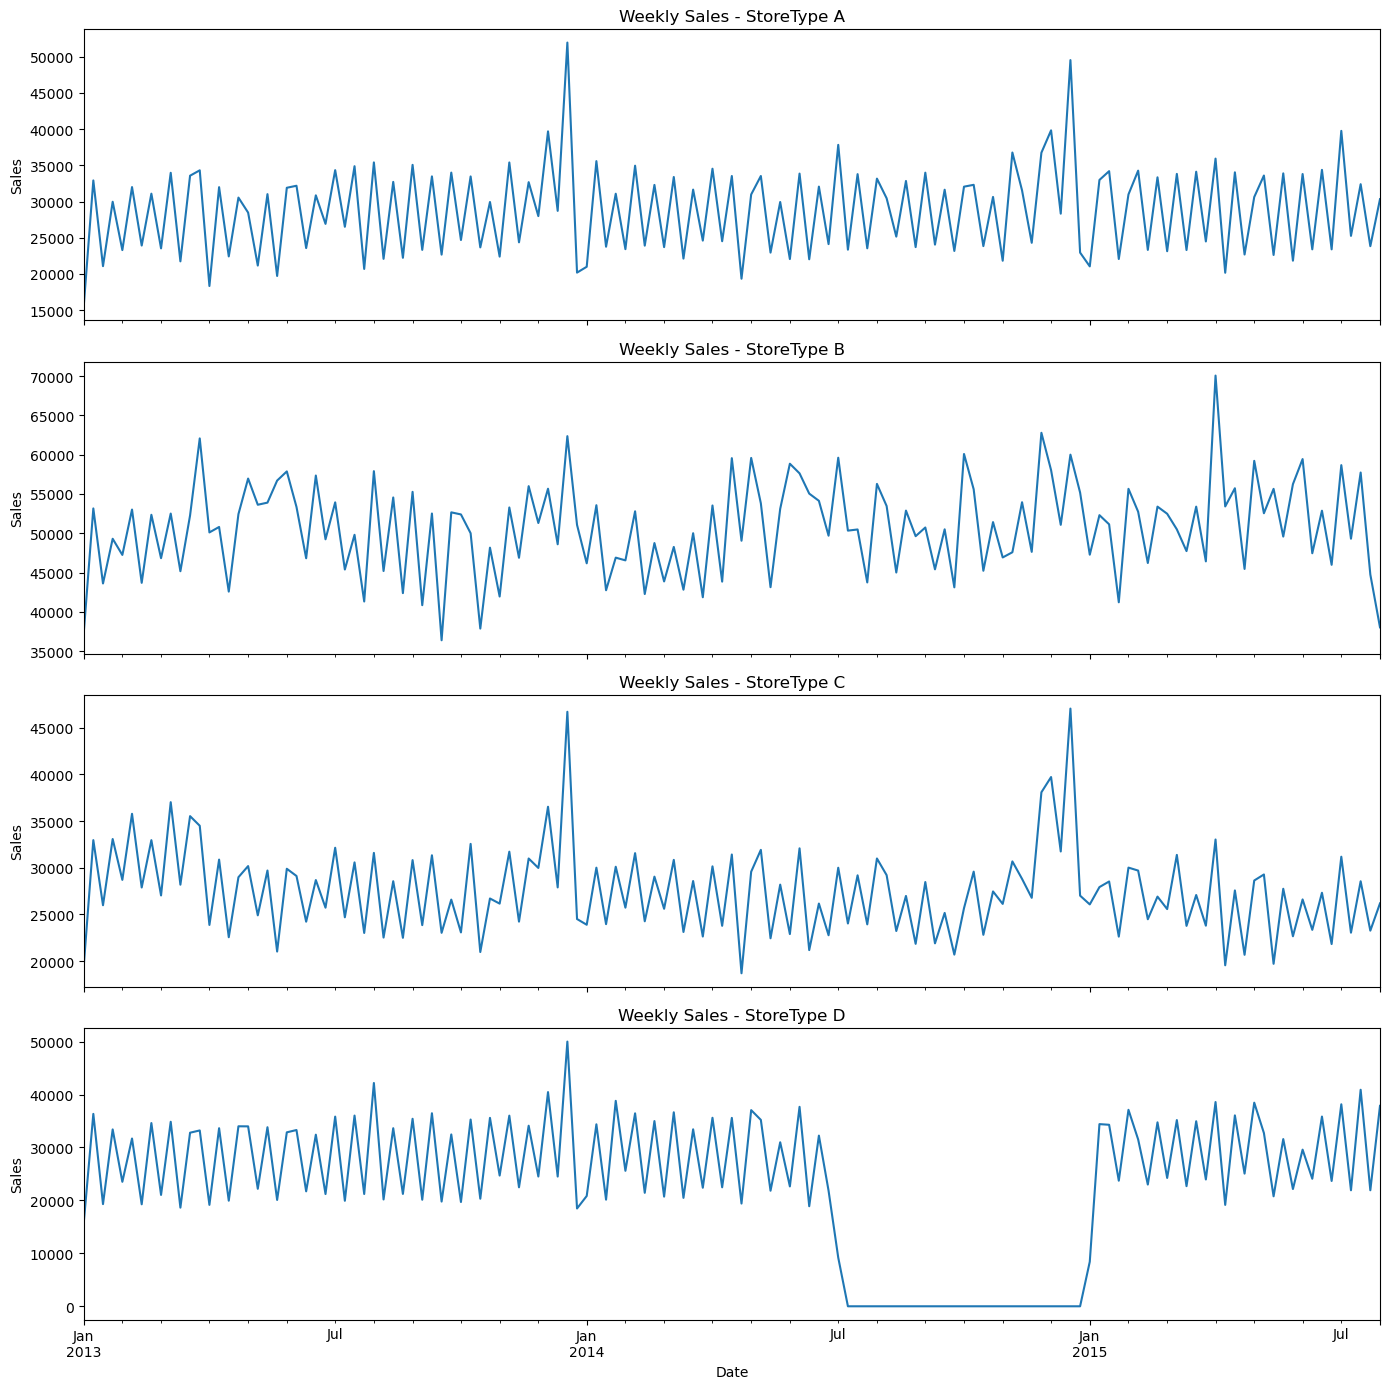

In [ ]:
# plot weekly aggregated sales for each selected store type
# create a figure with subplots for each store type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 14), sharex=True)

# iterate through the selected stores and plot their weekly sales trends
for idx, (store_type, store_id) in enumerate(stores.items()):
    # filter for specific store and set 'Date' as index. 
    store_data = filtered_data[filtered_data['Store'] == store_id].set_index('Date')

    # resample daily data into weekly totals using 'W' frequency
    # this aggregates the sales data into weekly totals, which helps in understanding the overall trend over time.
    weekly_sales = store_data['Sales'].resample('W').sum()

    # plot the weekly sales trend for the store type
    # the plot shows the total sales for each week, which helps in visualizing the sales trend over time.
    weekly_sales.plot(ax=axes[idx], title=f"Weekly Sales - StoreType {store_type}", legend=False)
    axes[idx].set_ylabel("Sales")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

The above graphs show the weekly total sales for a representative store from each StoreType (A to D), across 2013–2015. From these graphs, we have the following conclusions:
- StoreType A and C both show strong seasonality. They especially show seasonality around December because there are spikes in the graph. These graphs are likely due to holiday shopping from Christmas/New Years. 
- StoreType B is more volatile type of store because it has a wide range of weekly sales. Its weekly sales ranges between 35k and 70k.
- StoreType D has a missing segment around mid-2014 to early 2015. This may indicate that these specific type of store  may have been closed temporarily or have been closed due to other reasons.
- All types of stores (A, B, C, and D) show recurring weekly fluctuations. This indicates short-term seasonal cycles in customer purchases, most likely due to the amount of sales on a weekday compared to a weekend.




Now, after setting up the data set and trend/visuality for the store types, we can start the time series decomposition. 

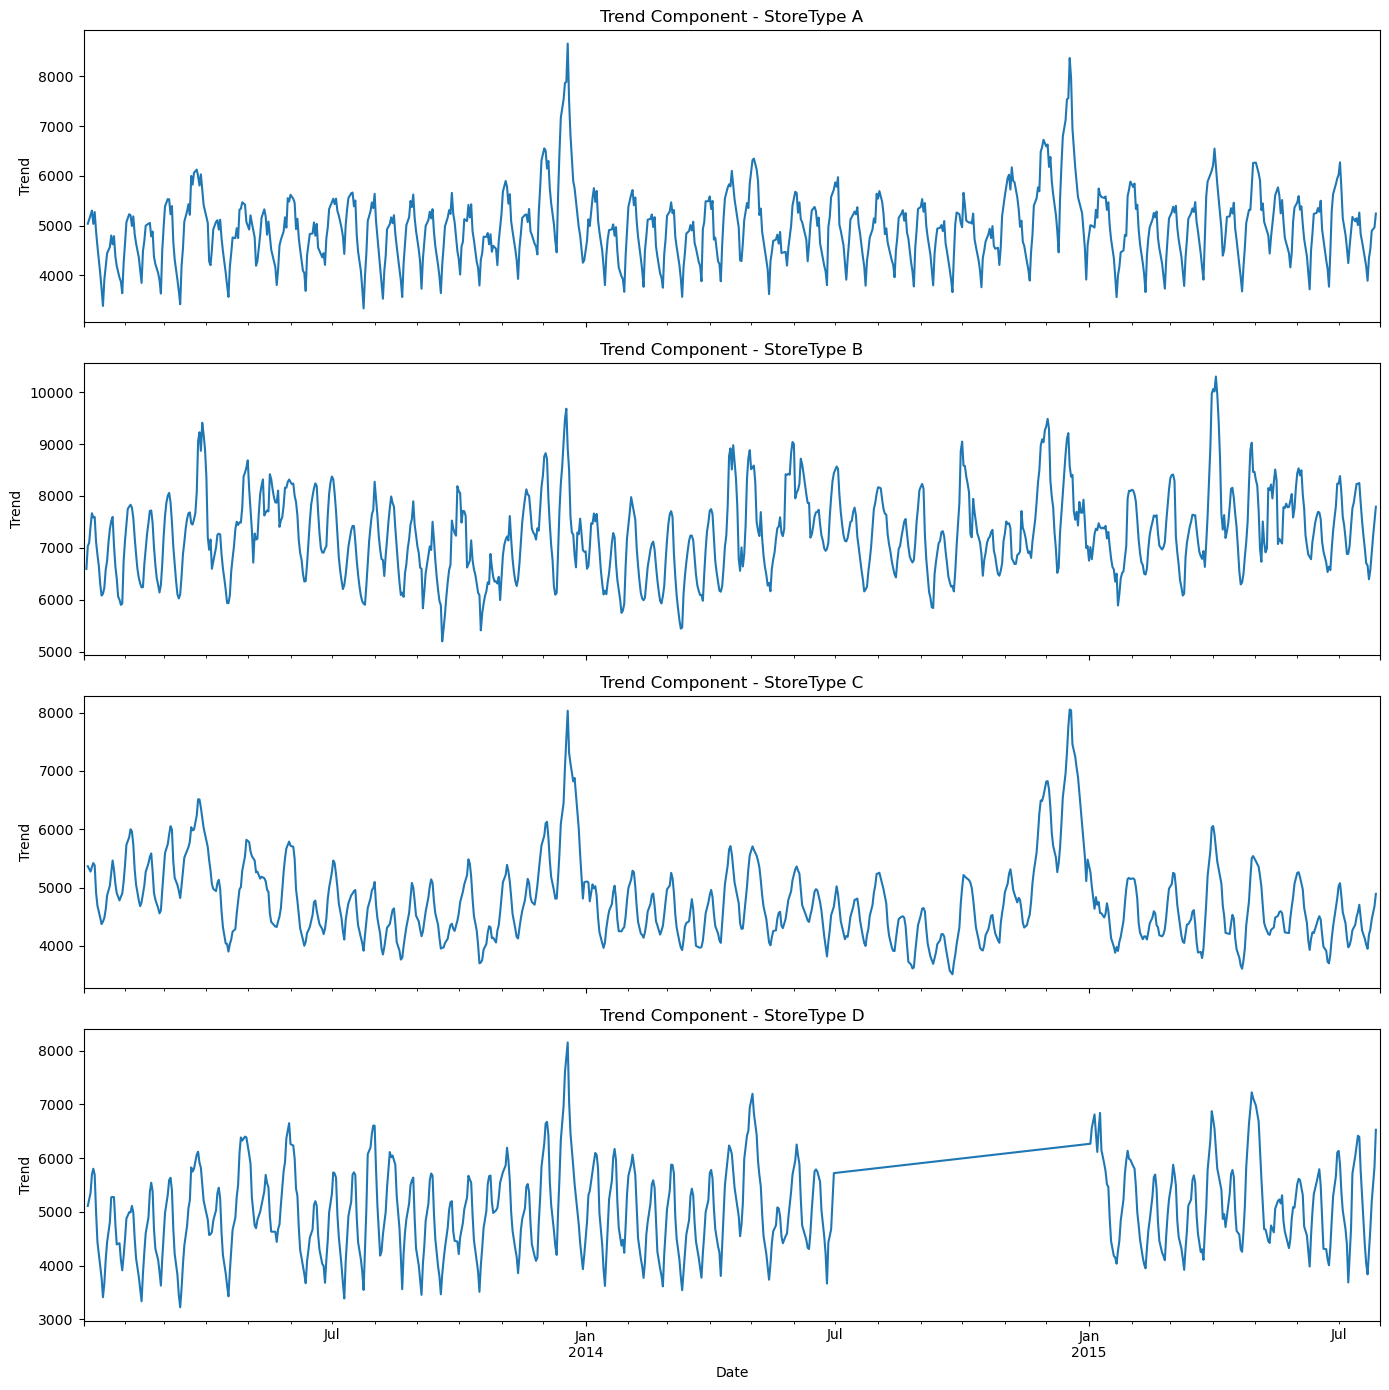

In [ ]:
# decompose seasonal trends for each store's daily sales data
# create a figure with subplots for each store type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 14), sharex=True)

# iterate through the selected stores and decompose their daily sales data
for idx, (store_type, store_id) in enumerate(stores.items()):
    # get daily sales data for decomposition 
    daily_sales = filtered_data[filtered_data['Store'] == store_id].set_index('Date')['Sales']

    # apply seasonal decomposition with a period of 7 days (weekly trend). We are using an additive model to decompose the time series into 
    # trend, seasonal, and residual components.The period of 7 is chosen because we expect weekly seasonality in the sales data.
    result = seasonal_decompose(daily_sales, model='additive', period=7)

    # plot only the trend component for each store type
    result.trend.plot(ax=axes[idx], title=f"Trend Component - StoreType {store_type}")
    axes[idx].set_ylabel("Trend")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


From the above graphs, we can trend components from seasonal decomposition. It shows the underlying trend in sales for each store after removing seasonality and noise. From these graphs, we can make the following conclusions:
- Store types A and B have trends that are mostly stable but still have some peaks. Both of these stores had some dips in 2015. 
- Store type C shows a decline in 2013, a strong holiday surge in late 2014, and then a small dip again. This dip could have been caused of possibly market saturation.
- Store type D shows a gap which confirms that the store of that type were closed. A flat line during mid 2014 means there was no data. The jump in 2015 likely marks the reopening of these types of stores.



## ML (Forecasting) Algorithm Training & Analysis

The Prophet model was trained on historical daily sales data from Store 1, representing store type C. The training dataset included features like sales volume, holiday indicators, and store status (if the store was opened or closed). The Prophet model was configured to:
- Fit trend and seasonal patterns
- Include custom holiday effects. This includes state and school holidays
- Forecast future sales for a 15-week horizon


After training the model, the model was evaluated visually by plotting:
- The forecast against actual data
- The decomposed components (trend, weekly and yearly seasonality, holiday effects)

Note: Because there isn't enough data to train the model on years, we trained the model on weeks instead. 

Below, we are specifically forecasting for Store type A (aka store 2.)

Because we are working with store 2, let us select that single store.


In [ ]:
# select data for a single store (Store #2 - StoreType A)
store_df = filtered_data[filtered_data['Store'] == 1][['Date', 'Sales']].copy()

Before we move on, let us set the x and y axis for better understanding.

In [ ]:
# prophet requires 'ds' for dates and 'y' for values
store_df.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
store_df = store_df.sort_values(by='ds')

Now, lets create datasets for the holidays and feed them into the model so it knows when the holidays are and fit the store data to those specific holidays. 

In [ ]:
# create holiday features from dataset
state_holidays = data[data['StateHoliday'].isin(['a', 'b', 'c'])]['Date']
school_holidays = data[data['SchoolHoliday'] == 1]['Date']

# build holidays DataFrame in Prophet's format
holiday_df = pd.concat([
    pd.DataFrame({'holiday': 'state_holiday', 'ds': pd.to_datetime(state_holidays)}),
    pd.DataFrame({'holiday': 'school_holiday', 'ds': pd.to_datetime(school_holidays)})
]).drop_duplicates()

# initialize Prophet model with holidays and wider uncertainty interval
model = Prophet(interval_width=0.95, holidays=holiday_df)

# fit the model to the store's data
model.fit(store_df)

23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing


Now lets create a dataframe for the next 7 weeks so we can predict future sales. 

In [ ]:
# create a future DataFrame extending 6 weeks (15*7 = 105 days)
future_dates = model.make_future_dataframe(periods=105)

# predict future sales
forecast = model.predict(future_dates)

Lastly, lets plot the data. 

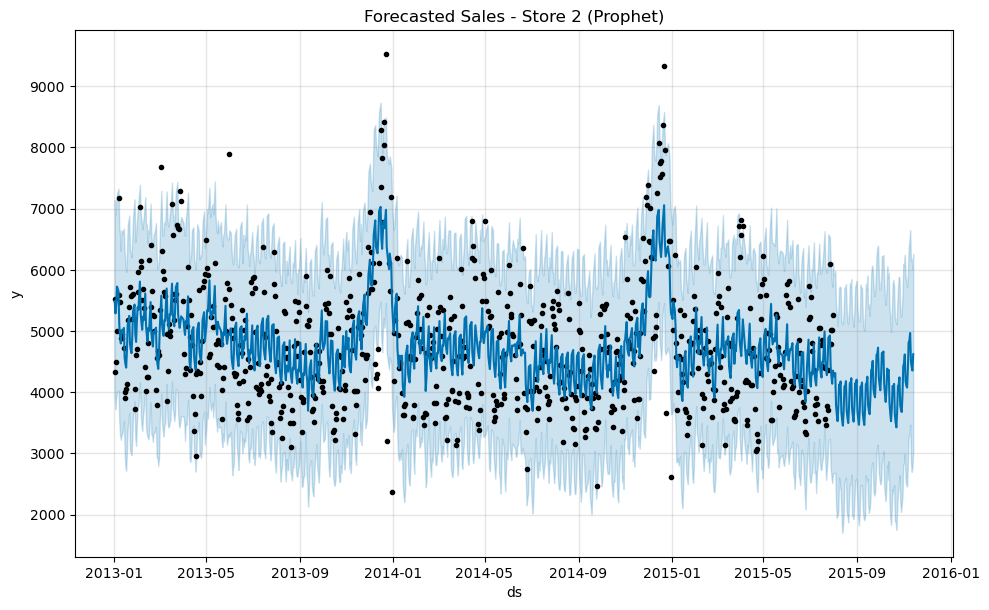

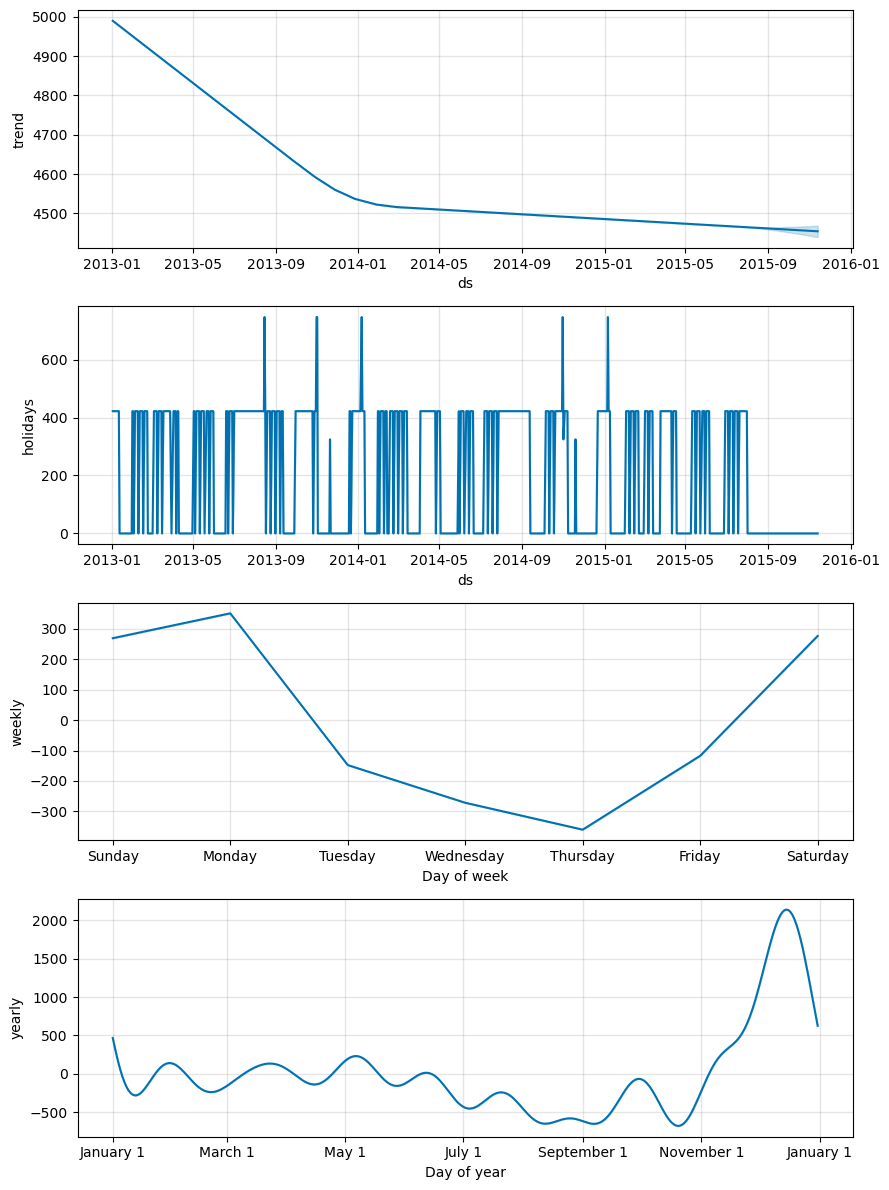

In [ ]:
# plot the forecast along with actual data
model.plot(forecast)
plt.title("Forecasted Sales - Store 2 (Prophet)")
plt.show()

# plot forecast components: trend, seasonality, holidays
model.plot_components(forecast)
plt.show()

From the above graphs above, we can conclude the following statements. 

**Forecasted Sales - Store 1 Graph**

*Seasonal Pattern*

There are clear, repeating spikes around late November to December in each year. This aligns with the holiday season and accounts for the following holidays: Black Friday, Christmas, and the New Year. The Prophet model successfully captures these spikes in the forecast, showing that it learned the yearly seasonality of the store's sales well.

*Forecast Accuracy*

Most black dots (actuals) fall within the blue shaded region, indicating that the model is reasonably accurate, especially for central seasonal trends and the conservative in its uncertainty bands, which is good in a business forecasting context.

*Over/Under Prediction*

In early 2013, the model slightly overestimates actuals. Additionally, around the holiday spikes, actual sales can sometimes overshoot the forecast, suggesting that the model captured the pattern, but not always the magnitude of extreme peaks. It also suggests that the model includes extra regressors like promotions which could improve the accuracy on peak days.

*Weekly Patterns*

The sawtooth wave pattern in the forecast shows Prophet also modeled weekly seasonality. The short, repeating dips likely reflect mid-week sales drops, which may include slow weekdays.

*Uncertainty Behavior*
The confidence intervals widen slightly toward the end of the timeframe, which is expected because as the Prophet model forecasts further into the future, it becomes less certain, so it expands its bounds.

**Graph 2 - Consisting of 4 graphs**

*Trend Component - Graph 1/4*

This graph shows the long-term direction of sales without seasonal or holiday effects. We can see that in early 2013, the sales for Store 2 began declining steadily and flattened out in early 2014. 

*Holiday Effects - Graph 2/4*

This graph shows the impact of state and school holidays on sales over time. We can see frequent spikes, which indicates that holidays often result in temporary increases in sales. These holidays are most likely public holidays or school breaks where customer foot traffic increases. The model successfully models these as positive contributors to short-term sales.

*Weekly Seasonality - Graph 3/4*

This graph shows the average expected sales fluctuations across the days of the week. From the graph, we can see that the sales are the highest on Mondays and Saturdays. This is probably due to Monday restocks/shopping after the weekend and/or Saturday shopping peaks before the weekend. Sales dip midweek, especially on Wednesdays and Thursdays, to show that there is low-traffic on these days and not much sale is made. This cycle is common in retail stores and the model captures it.

*Yearly Seasonality - Graph 4/4*

This graph shows how the sales change over the course of a year. This is averaged across multiple years. The model detects a sharp spike in December, peaking just before January, which is consistent about what we said about holiday shopping earlier. There’s a dip in mid-year, arouund June to August, which could be due to summer vacations or less promotional activity. Lastly, there are small bumps across the year that may reflect seasonal campaigns or school calendar effects.

## Analysis & Conclusion